In [1]:
%matplotlib inline

In [49]:
import matplotlib as mpl
from matplotlib import pyplot as pl

mplparams = {
      'text.usetex': True, # use LaTeX for all text
      'axes.linewidth': 0.5, # set axes linewidths to 0.5
      'axes.grid': False, # add a grid
      'font.family': 'serif',
      'font.size': 12 }

mpl.rcParams.update(mplparams)

In [3]:
import numpy as np

In [4]:
import matplotlib.gridspec as gridspec

In [59]:
# copy the 2D greedy kde contour plotting from plotutils (http://farr.github.io/plotutils/_modules/plotutils/plotutils.html#plot_greedy_kde_interval_2d) - Copyright: Will Farr @farr
import scipy.stats as ss

def plot_2d_contours(ax, pts, levels, xmin=None, xmax=None, ymin=None, ymax=None, Nx=100, Ny=100, cmap=None, colors=None):
    """Plots the given probability interval contours, using a greedy
    selection algorithm.

    The algorithm uses a two-step process (see `this document
    <https://dcc.ligo.org/LIGO-P1400054/public>`_) so that the
    resulting credible areas will be unbiased.

    :param ax: a matplotlib axis on which to plot the contours

    :param pts: Array of shape ``(Npts, 2)`` that contains the points
      in question.

    :param levels: Sequence of levels (between 0 and 1) of probability
      intervals to plot.

    :param xmin: Minimum value in x.  If ``None``, use minimum data
      value.

    :param xmax: Maximum value in x.  If ``None``, use minimum data
      value.

    :param ymin: Minimum value in y.  If ``None``, use minimum data
      value.
    
    :param ymax: Maximum value in y.  If ``None``, use minimum data
      value.

    :param Nx: Number of subdivisions in x for contour plot.  (Default
      100.)

    :param Ny: Number of subdivisions in y for contour plot.  (Default
      100.)

    :param cmap: See :func:`pp.contour`.

    :param colors: See :func:`pp.contour`.

    """

    Npts = pts.shape[0]
    
    kde_pts = pts[:Npts/2,:]
    den_pts = pts[Npts/2:,:]

    Nkde = kde_pts.shape[0]
    Nden = den_pts.shape[0]

    kde = ss.gaussian_kde(kde_pts.T)
    den = kde(den_pts.T)
    densort = np.sort(den)[::-1]

    if xmin is None:
        xmin = np.min(pts[:,0])
    if xmax is None:
        xmax = np.max(pts[:,0])
    if ymin is None:
        ymin = np.min(pts[:,1])
    if ymax is None:
        ymax = np.max(pts[:,1])

    xs = np.linspace(xmin, xmax, Nx)
    ys = np.linspace(ymin, ymax, Ny)

    XS, YS = np.meshgrid(xs,ys)
    ZS = np.reshape(kde(np.row_stack((XS.flatten(), YS.flatten()))), (Nx, Ny))

    zvalues=[]
    for level in levels:
        ilevel = int(Nden*level + 0.5)
        if ilevel >= Nden:
            ilevel = Nden-1
        zvalues.append(densort[ilevel])

    ax.contour(XS, YS, ZS, zvalues, colors='k')

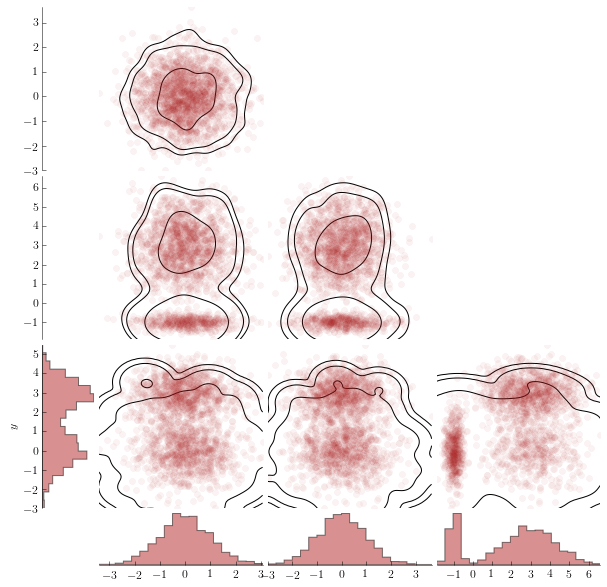

In [60]:
# number of parameters
ndims = 4

# ratio of joint plots to histogram plots
ratio = 3

gridsize = ratio*(ndims-1) + 1

gs = gridspec.GridSpec(gridsize, gridsize, wspace=0.1, hspace=0.1)
f = pl.figure(figsize=(10,10))
x = np.zeros((2000,ndims))
x[:,0:2] = np.random.randn(2000,2)
x[0:500,2] = -1. + 0.25*np.random.randn(500)
x[500:2000,2] = 3. + 1.25*np.random.randn(1500)
x[0:1000, 3] = 1.*np.random.randn(1000)
x[1000:2000, 3] = 3.+0.75*np.random.randn(1000)
#x = np.random.randn(1000, ndims)

labels = ['blah', '$x$', '$\phi$', '$y$']

# set axes for the histograms
histaxes = []
histaxes.append(f.add_subplot(gs[ratio*(ndims-2):-1,0]))

#histvert = [None for i in range(ndims-1)] # empty subplots, but axes are required
histvert = []
for i in range(ndims-1):
    ax = f.add_subplot(gs[i*ratio:(i+1)*ratio,0])
    ax.spines['top'].set_visible(False)    # remove top border
    ax.spines['bottom'].set_visible(False) # remove bottom border
    ax.spines['right'].set_visible(False)  # remove right border
    ax.set_xticklabels([])
    ax.set_xticks([])
    ax.yaxis.set_ticks_position('left') # just show ticks on left
    histvert.append(ax)

# plot horizontal histogram
histvert[-1].hist(x[:,-1], bins=20, histtype='stepfilled', normed=True, orientation='horizontal', color='firebrick', alpha=0.5)
histvert[-1].set_ylabel(labels[-1])

#histhori = [None for i in range(ndims-1)]
histhori = []
for i in range(ndims-1):
    ax = f.add_subplot(gs[-1,(i*ratio+1):(1+(i+1)*ratio)])
    ax.spines['top'].set_visible(False)    # remove top border
    ax.spines['left'].set_visible(False)   # remove left border
    ax.spines['right'].set_visible(False)  # remove right border
    ax.set_yticklabels([])
    ax.set_yticks([])
    ax.xaxis.set_ticks_position('bottom') # just show ticks on left
    ax.hist(x[:,i], bins=20, histtype='stepfilled', normed=True, color='firebrick', alpha=0.5)
    histhori.append(ax)

jointaxes = []
for i in range(ndims-1):
    for j in range(i+1):
        ax = f.add_subplot(gs[i*ratio:(i+1)*ratio,(j*ratio+1):(1+(j+1)*ratio)], sharey=histvert[i], sharex=histhori[j])
        ax.spines['top'].set_visible(False)    # remove top border
        ax.spines['left'].set_visible(False)   # remove bottom border
        ax.spines['right'].set_visible(False)  # remove right border
        ax.spines['bottom'].set_visible(False) # remove bottom border

        pl.setp(ax.get_xticklabels(), visible=False) # remove xtick labels
        pl.setp(ax.get_yticklabels(), visible=False) # remove ytick labels
        ax.tick_params(bottom='off', top='off', left='off', right='off') # remove tick marks 

        # plot joint distribution
        ax.plot(x[:,j], x[:,i+1], 'o', c='firebrick', ms=6, mfc='firebrick', alpha=0.05, markeredgecolor='firebrick') # plot scatter
        plot_2d_contours(ax, np.vstack((x[:,j], x[:,i+1])).T, (0.5, 0.9, 0.95))
        jointaxes.append(ax)
